# Annual Water Use 

In [1]:

import os, sys
import pandas as pd

from iwateruse.featurize import MultiOneHotEncoder
import matplotlib.pyplot as plt
from xgboost import plot_importance
import xgboost as xgb
import category_encoders as ce 
from lightgbm import LGBMRegressor

#
import numpy as np

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

C:\Miniconda3\envs\py39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Miniconda3\envs\py39\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
%matplotlib widget
%matplotlib inline
%matplotlib ipympl
import warnings

warnings.filterwarnings('ignore')
xgb.set_config(verbosity=0)

In [4]:
dataset = pd.read_csv(r"C:\work\water_use\ml_experiments\annual_v_0_0\clean_train_db.csv")
# pop_info = pd.read_csv(r"pop_info.csv")
# pc_50_swud = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\misc_features\spatial_features\pc_50_pop_swud15.csv")
# pc_50_plc = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\misc_features\spatial_features\pc_50_plc_pop_interpolated.csv")
# pc95_5 = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\misc_features\spatial_features\pc_50_swud_pop_p95_5.csv")

In [5]:
df_ = pc_50_swud[['sys_id', 'pc_median' ]]
dataset = dataset.merge(df_, right_on=['sys_id'], left_on=['sys_id'] , how = 'left')
del(df_)

df_ = pc95_5[['sys_id', 'p95', 'p5' ]]
dataset = dataset.merge(df_, right_on=['sys_id'], left_on=['sys_id'] , how = 'left')
del(df_)

In [6]:
pop_info

,sys_id,pop,tract_pop,cdc_pop_0,plc_pop_interpolated,zillow_nh,bdg_ftp_count,wu_rate,WSA_SQKM,pop_swud15,...,pz_tpop,pz_swud,pf_tract,pf_plc,pf_tpop,pf_swud,Year,LAT,LONG,Ecode_num
0,100211202,0,740.290388,19.927953,1106.956079,NaN,NaN,NaN,6.021133,1018.761996,...,NaN,NaN,NaN,NaN,NaN,NaN,2000,55.143611,-131.593056,0.0
1,100211202,0,762.662364,102.304079,1101.857372,NaN,NaN,NaN,6.021133,1049.549535,...,NaN,NaN,NaN,NaN,NaN,NaN,2001,55.143611,-131.593056,0.0
2,100211202,0,785.034341,184.680512,1096.758665,NaN,NaN,NaN,6.021133,1080.337073,...,NaN,NaN,NaN,NaN,NaN,NaN,2002,55.143611,-131.593056,0.0
3,100211202,0,807.406317,267.056946,1091.659958,NaN,NaN,NaN,6.021133,1111.124612,...,NaN,NaN,NaN,NaN,NaN,NaN,2003,55.143611,-131.593056,0.0
4,100211202,0,829.778293,349.433688,1086.561252,NaN,NaN,NaN,6.021133,1141.912151,...,NaN,NaN,NaN,NaN,NaN,NaN,2004,55.143611,-131.593056,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417286,WY5680092,0,0.371218,0.371218,109.138817,NaN,186.0,NaN,2.040843,NaN,...,NaN,NaN,-2.699884,-0.231534,0.216837,NaN,2016,44.973341,-110.692678,0.0
417287,WY5680092,0,0.379047,0.379047,56.552770,NaN,186.0,NaN,2.040843,NaN,...,NaN,NaN,-2.690820,-0.517059,0.225901,NaN,2017,44.973341,-110.692678,0.0
417288,WY5680092,0,0.387101,0.387101,50.463745,NaN,186.0,NaN,2.040843,NaN,...,NaN,NaN,-2.681688,-0.566533,0.235033,NaN,2018,44.973341,-110.692678,0.0
417289,WY5680092,0,0.388307,0.388307,48.391644,NaN,186.0,NaN,2.040843,NaN,...,NaN,NaN,-2.680338,-0.584743,0.236384,NaN,2019,44.973341,-110.692678,0.0


In [7]:
pop_info['pop'] = pop_info['pop_swud16'].copy()
mask = pop_info['pop'].isna() | pop_info['pop']==0
pop_info.loc[mask, 'pop'] = pop_info[mask]['plc_pop_interpolated']
mask = pop_info['pop'].isna() | pop_info['pop']==0
pop_info.loc[mask, 'pop'] = pop_info[mask]['TPOPSRV']
mask = pop_info['pop'].isna() | pop_info['pop']==0
pop_info.loc[mask, 'pop'] = pop_info[mask]['tract_pop']


#dataset = dataset[dataset['Ecode_num']==0]

pop_df = pop_info[['sys_id', 'pop', 'Year']]
dataset = dataset.merge(pop_df, right_on=['sys_id', 'Year'], left_on=['sys_id', 'Year'] , how = 'left')

In [8]:
dataset_bck = dataset.copy()

In [9]:
# drop_before_preprocess = ['sys_id']
# categorical_features = ['HUC2', 'state_id',  'KG_climate_zone', 'county_id', 'Ecode_num' ]
# ohc1 = MultiOneHotEncoder(catfeatures = categorical_features )
# dataset = ohc1.transform(dataset)

In [10]:
dataset = dataset_bck.copy()

In [11]:
categorical_features = ['HUC2', 'state_id']
# dataset = dataset.astype({"HUC2":'category', "state_id":'category',
#                       "KG_climate_zone":'category',
#                       "Ecode_num":'category',}) #"county_id":'category',

In [12]:
#ordered_features

In [13]:
extra_drop = []

In [15]:
#extra_drop = ordered_features[50:].to_list()
extra_drop = []
for i in ['KG_climate_zone', 'HUC2', 'state_id', 'Ecode_num', 'county_id', "KG_climate_zone"]:
    try:
        extra_drop.remove(i)
    except:
        print(" {} is not the list".format(i))

 KG_climate_zone is not the list
 HUC2 is not the list
 state_id is not the list
 Ecode_num is not the list
 county_id is not the list
 KG_climate_zone is not the list


In [50]:

def log_cosh_quantile(alpha):
    def _log_cosh_quantile(y_true, y_pred):
        err = y_pred - y_true
        err = np.where(err < 0, alpha * err, (1 - alpha) * err)
        grad = np.tanh(err)
        hess = 1 / np.cosh(err)**2
        hess[hess<0.01] =0.01 
        #hess = np.ones_like(hess)
        
        return grad, hess
    return _log_cosh_quantile

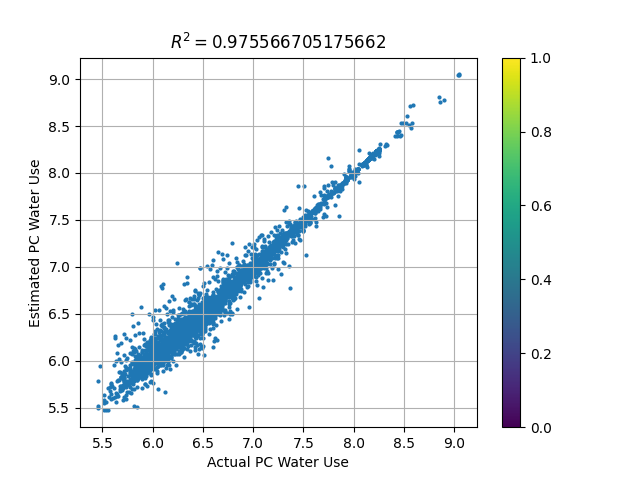

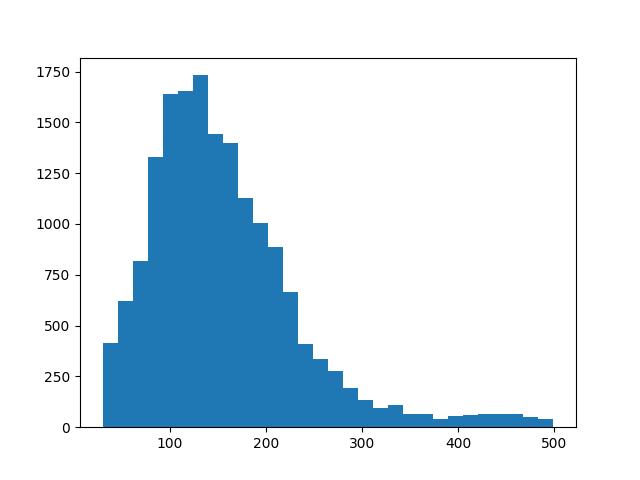

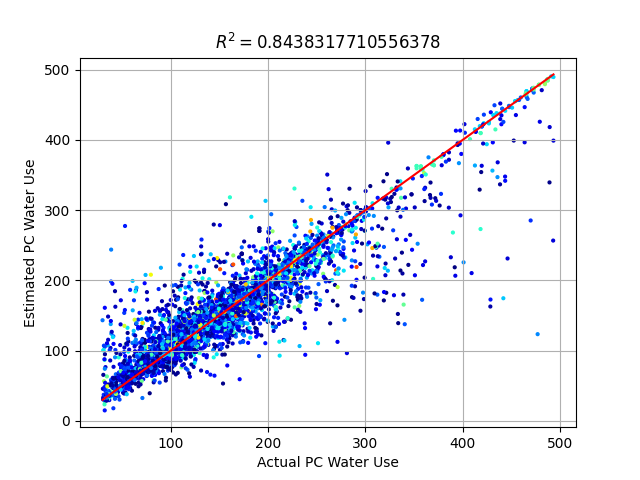

In [18]:

columns_to_drop = [ 'population','sys_id', 'wu_rate'] + extra_drop#'population',
df = dataset.copy()
#df['pc_median']
df['pc'] = df['wu_rate']/df['pop']
if 1:
    df = df[df['pop']>8000]
    mask = (df['pc']>30) & (df['pc']<500)
    df = df[mask]
    #df = df[df['pc']<df['p95']]
    #df = df[df['pc']>df['p5']]

#mask = ((df['pc_median']-df['pc'])/df['pc_median']) <0.5
#df = df[mask]

df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('pc')
X =df[features]
from statsmodels.distributions.empirical_distribution import ECDF
# y = df['pc'].values
# ec = ECDF(y)
# y = ec(y)
y =df['pc']

# 
plt.figure()
v_freq = plt.hist(df['pc'].values, bins = 30)
freq = np.interp(df['pc'].values, v_freq[1][1:], v_freq[0], left=None, right=None, period=None)
X['freq'] = freq

tar_ec = ce.TargetEncoder(return_df=True, cols = ['county_id'] )
#X = tar_ec.fit_transform(X, y)

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 123)
Train_freq = X_train['freq']
Test_freq = X_test['freq']
del(X_test['freq'])
del(X_train['freq'])

lgb_params = {
    'n_jobs': 1,
    'max_depth': 8,
    'min_data_in_leaf': 20,
    'subsample': 0.5,
    'n_estimators': 500,
    'learning_rate': 0.2,
    'colsample_bytree': 0.5,
    'boosting_type': 'gbdt',
   
}

# Estimator  -- reg:squaredlogerror, "reg:squarederror"
if 1:
    gb = xgb.XGBRegressor(objective="reg:squarederror", tree_method = 'hist', colsample_bytree=0.8, learning_rate=0.20,
                                  max_depth=7, alpha=100,  n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                                  seed = 123, reg_lambda=10, min_child_weight = 1, gamma = 10, max_delta_step = 0, 
                               )
else:
    gb = LGBMRegressor(objective='regression', alpha=quantile_alpha, **lgb_params)


main_pipeline = []

# (A.2) transformation of categorical features

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# (A.3)do all preprocessing
if 1: # r2 = 0.785
    preprocessor = ColumnTransformer(remainder = 'passthrough',
        transformers=[       
            ("cat", categorical_transformer, categorical_features),
            ('Target encoding', ce.OneHotEncoder( cols = ['county_id',
                                                          'KG_climate_zone']), ['county_id','KG_climate_zone' ])
        ]
    )
    main_pipeline.append(('preprocess', preprocessor))

# drop r2 to 0.774
if 0:
    from feature_engine.encoding import CountFrequencyEncoder
    encoder = CountFrequencyEncoder(encoding_method='frequency',
                             variables=categorical_features)
    main_pipeline.append(('enc', encoder))

# drop r2 to 0.663 for ordered and 0.78 for arbitrary
if 0:    
    from feature_engine.encoding import OrdinalEncoder
    encoder = OrdinalEncoder(encoding_method='ordered',
                             variables=categorical_features)
    main_pipeline.append(('enc', encoder))

#***************************




main_pipeline.append(('model', gb))

model = Pipeline(main_pipeline)



w = 1.0/Train_freq
w = w/np.max(w)

kwargs = {model.steps[-1][0] + '__sample_weight': w/w}
model.fit(X_train, y_train, **kwargs)

plt.figure()
ypredict = model.predict(X_test)

w2 = 1.0/Test_freq
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4, c = np.log10(X_test['pop']), cmap = 'jet')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()

plt.figure()
plt.scatter(np.log10(y_test*X_test['pop']), np.log10(ypredict*X_test['pop']), s = 4)
accuracy =  r2_score(np.log10(y_test*X_test['pop']),  np.log10(ypredict*X_test['pop']))
#plt.plot([min(y_test*X_test['pop']), max(ypredict*X_test['pop'])], [min(y_test*X_test['pop']), max(y_test)*X_test['pop']], 'r')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()

plt.colorbar()
plt.show()

In [19]:
e = np.abs(y_test- ypredict)
mask = e>150

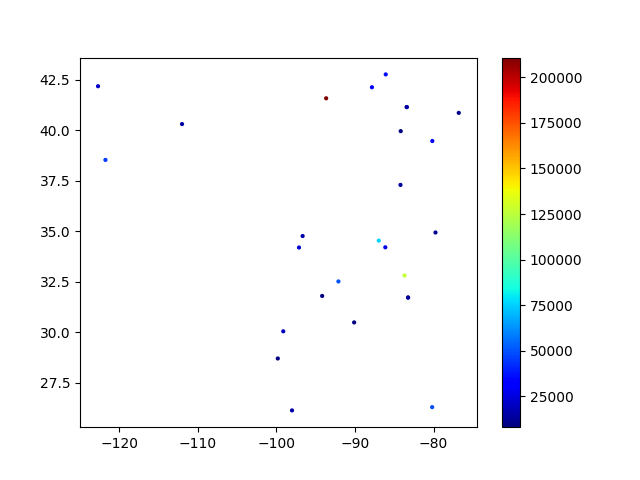

In [20]:
plt.figure()
plt.scatter(X_test[mask]['LONG'], X_test[mask]['LAT'], c =  X_test[mask]['pop'], cmap = 'jet', s = 4)
plt.colorbar()

In [117]:
X_test.LONG

26636   -98.128897
79653   -89.289222
16238   -98.493628
40656   -77.111367
57157   -88.123444
           ...    
60421   -83.448253
74316   -85.945804
55890   -86.895030
66535   -81.561514
7969    -98.871984
Name: LONG, Length: 5184, dtype: float64

In [105]:
features = X_test.columns
imp = []
for feature in features:
    X_test_permutated = X_test.copy()
    val = X_test_permutated[feature].sample(frac = 1)
    val = val.values
    X_test_permutated[feature] = val
    y_predicted_per = model.predict(X_test_permutated)
    accuracy = r2_score(y_test, y_predicted_per)
    print(accuracy)
    imp.append(accuracy - 0.7714)

0.8261757275140588
0.8300145107038637
0.8289705688443063
0.8295849535007327
0.8322888445091512
0.8317111069889763
0.8317130146115846
0.8322312053131732
0.8293956817606779
0.8313377395065957
0.8320861679958609
0.8282614392082316
0.8303065908980113
0.8287284014335734
0.8314484838001902
0.8330978919573575
0.8309443781306212
0.8312511871041476
0.8299264180895092
0.8303857244951136
0.804505998687792
0.831936045809315
0.8312928767480682
0.828385423736627
0.8295705677191965
0.8292071927917084
0.8312250725249414
0.8327032209516617
0.832851892867972
0.8319261402536672
0.8328085767370238
0.8329677213594164
0.8329900380249111
0.831476163856531
0.8345755189546894
0.8303104717747491
0.830808368161045
0.8273780865525628
0.8330317279161863
0.8320122416183873
0.8321084036315153
0.8318892352163496
0.8339614698216457
0.8339453443955073
0.8315173843819665
0.832870186024824
0.8316895016982865
0.8311183728972215
0.8345836085453694
0.8268854234771313
0.8315673307390501
0.8334763285983214
0.8313716875803864


In [100]:
from statsmodels.distributions.empirical_distribution import ECDF

In [37]:
x = df['pc'].values
ec = ECDF(x)

In [39]:
ec(x)

array([0.13376575, 0.27023221, 0.06580952, ..., 0.15694105, 0.15694105,
       0.10318083])

In [ ]:
ytrain_predicted = model.predict(X_train)
plt.figure()




accuracy = r2_score(y_train, ytrain_predicted)
accuracy

plt.scatter(y_train, ytrain_predicted, s = 4)
plt.plot([min(y_train), max(y_train)], [min(ytrain_predicted), max(ytrain_predicted)], 'r')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()

plt.colorbar()
plt.show()

## Meaure Importance 

0.7674163988036788
0.7668648225397214
0.765899667549486
0.7670078004075138
0.7675753812602908
0.7672076184882005
0.766910162770956
0.7655077652948741
0.767582206947887
0.7675822162701205
0.7680177890712533
0.7667441327792768
0.7639380125346551
0.7683998605355207
0.7667163646005595
0.7677925489490968
0.762017954020817
0.7603747265878886
0.7677004095381703
0.767763877233477
0.7672556047091174
0.7667935135415064
0.7682970763505835
0.7667222733978921
0.7678000677198706
0.767948253177121
0.7661540489351871
0.7688603117300837
0.7697193297212099
0.7677326874298679
0.770150287704876
0.7679484554092937
0.7696058563093826
0.7683539026551378
0.7706134076810244
0.764268799164615
0.7684102570048328
0.768492208371347
0.7685393433693448
0.769454974354103
0.769164475595382
0.7671204603547788
0.7692729649773906
0.7679545668068166
0.7681913807172234
0.7670371489782772
0.7691959997585613
0.7674610921212914
0.7710046932930881
0.762050346521127
0.7660287403195596
0.7691700026820716
0.768759286994978
0.7667

<BarContainer object of 50 artists>

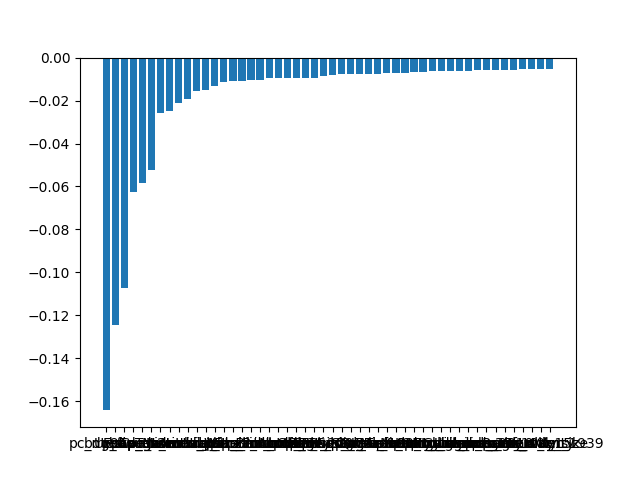

In [51]:
features = X_test.columns
imp = []
for feature in features:
    X_test_permutated = X_test.copy()
    val = X_test_permutated[feature].sample(frac = 1)
    val = val.values
    X_test_permutated[feature] = val
    y_predicted_per = model.predict(X_test_permutated)
    accuracy = r2_score(y_test, y_predicted_per)
    print(accuracy)
    imp.append(accuracy - 0.7714)
    
imp = np.array(imp)   
plt.figure()
plt.bar(features[np.argsort(imp)][0:50], imp[np.argsort(imp)[0:50]]) 

In [54]:
ordered_features = features[np.argsort(imp)]

In [106]:
features = np.array(features)
feat_to_drop = features[np.argsort(imp)][70:]
feat_to_drop = feat_to_drop.tolist()

In [107]:
feat_to_drop = feat_to_drop.tolist()

AttributeError: 'list' object has no attribute 'tolist'

In [108]:
feat_to_drop

['h_age_1970_1979',
 'Conservation',
 'income_45k_50k',
 'etr',
 'income_125k_150k',
 'n_occ_const_maint_repair',
 'n_ind_prof_sci_admin_waste',
 'bdg_ftp_count',
 'etr_warm',
 'n_ind_arts_entertain_foodservice',
 'income_25k_30k',
 'income_30k_35k',
 'n_ind_trans_warehouse_utilities',
 'n_occ_management',
 'h_age_1980_1989',
 'tmmx',
 'n_ind_wholesale_trade',
 'income_50k_60k',
 'n_ind_retail_trade',
 'HUC2',
 'county_tot_pop_2010',
 'income_35k_40k',
 'income_20k_25k',
 'n_employed',
 'n_houses',
 'n_occ_service',
 'n_occupation',
 'n_ind_education_healthcare',
 'n_occ_sales_office',
 'n_occ_farm_fish_forest',
 'n_ind_manufacturing',
 'tmmx_cool',
 'income_150k_200k',
 'Num_establishments_2017',
 'tmmn',
 'KG_climate_zone',
 'etr_cool',
 'pr_cool',
 'n_ind_finance',
 'n_ind_information',
 'n_occ_prod_trans_material',
 'n_ind_publicadmin']

In [45]:
feat_to_drop.remove('KG_climate_zone')

In [ ]:
plt.figure()
plt.bar(features[np.argsort(imp)][0:50], imp[np.argsort(imp)[0:50]])

In [ ]:
imp[np.argsort(imp)[0:50]]

In [ ]:
len(features)-60

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.decomposition import PCA

pipeline = Pipeline([ ('disc', KBinsDiscretizer(n_bins=1000, encode='ordinal', strategy='uniform')),                     
                    ('model', gb)])
kwargs = {pipeline.steps[-1][0] + '__sample_weight': w/w}
pipeline.fit(X_train, y_train, **kwargs)

plt.figure()
ypredict = pipeline.predict(X_test)

w2 = 1.0/Test_freq
#w2 = w2/np.sum(w)
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

## Pipeline
### Categorical encoding

In [ ]:
# (A.2) transformation of categorical features
categorical_features = ['HUC2', 'state_id',  'KG_climate_zone', 'county_id' ]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")



In [ ]:
# drop_before_preprocess = ['sys_id']
# categorical_features = ['HUC2', 'state_id',  'KG_climate_zone', 'county_id' ]
# ohc1 = MultiOneHotEncoder(catfeatures = categorical_features )
# dataset = ohc1.transform(dataset)

In [ ]:
# for i in dataset.columns:
#     print(i)

# Estimating Water Use without Log transformation

In [ ]:
# columns to drop
columns_to_drop = ['population', 'sys_id', 'pc']
df = dataset.copy()
df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]

df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('wu_rate')
X =df[features]
y = df['wu_rate']

In [ ]:
df.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [ ]:
#squaredlogerror
#squarederror
gb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.1,
                              max_depth=7, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=0.0)

In [ ]:
gb.fit(X_train, y_train)

In [ ]:
ypredict = gb.predict(X_test)
accuracy = r2_score(y_test, ypredict)

In [ ]:
plt.figure()
accuracy = int(accuracy*100)/100.0
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual Water Use")
plt.ylabel("Estimated Water Use")
plt.grid()
plt.show()

## Log water use & population 

In [ ]:
# columns to drop
columns_to_drop = ['population', 'sys_id', 'pc']
df = dataset.copy()
df = df[df['wu_rate']>100]
df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]

df = df.drop(columns_to_drop, axis=1)
df['pop'] = np.log10(df['pop'])
df['wu_rate'] = np.log10(df['wu_rate'])
features = list(df.columns)
features.remove('wu_rate')


X =df[features]
y = df['wu_rate']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [ ]:
gb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.01,
                              max_depth=7, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=0.0)

In [ ]:
gb.fit(X_train, y_train)

In [ ]:
ypredict = gb.predict(X_test)
accuracy = r2_score(y_test, ypredict)
accuracy

In [ ]:
plt.figure()
accuracy = int(accuracy*100)/100.0
plt.scatter(10**y_test, 10**ypredict, s = 4)
plt.plot([min(10**y_test), max(10**y_test)], [min(10**y_test), max(10**y_test)], 'r')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual Water Use")
plt.ylabel("Estimated Water Use")
plt.grid()
plt.show()

In [ ]:
plt.figure()
pc_test = (10**y_test)/(10**X_test['pop'])
pc_predict =  (10**ypredict)/(10**X_test['pop'])
accuracy = r2_score(pc_test, pc_predict )
plt.scatter(pc_test, pc_predict, s = 4)

plt.plot([min(pc_test), max(pc_test)], [min(pc_test), max(pc_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual Water Use")
plt.ylabel("Estimated Water Use")
plt.grid()
plt.show()

## Quantile Regression

## Use Xgboost

In [ ]:
# # columns to drop
# columns_to_drop = ['population', 'sys_id', 'pc']
# df = dataset.copy()
# df = df[df['wu_rate']>0]
# df['pc'] = df['wu_rate']/df['pop']
# df = df[df['pop']>1000]
# mask = (df['pc']>20) & (df['pc']<400)
# df = df[mask]

# df = df.drop(columns_to_drop, axis=1)
# df['pop'] = np.log10(df['pop'])
# df['wu_rate'] = np.log10(df['wu_rate'])
# features = list(df.columns)
# features.remove('wu_rate')


# X =df[features]
# y = df['wu_rate']

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [ ]:
def myfunc(quantile):
    def _myfunc(y_true, y_pred):
        errors = y_pred - y_true
        left_mask = errors < 0
        right_mask = errors > 0

        grad = -quantile * left_mask + (1 - quantile) * right_mask
        hess =  np.ones_like(y_pred)

        return grad, hess
    return _myfunc

In [ ]:
# log cosh quantile is a regularized quantile loss function
def log_cosh_quantile(alpha):
    def _log_cosh_quantile(y_true, y_pred):
        err = y_pred - y_true
        err = np.where(err < 0, alpha * err, (1 - alpha) * err)
        grad = np.tanh(err)
        hess = 1 / np.cosh(err)**2
        hess[hess<0.01] =0.01 
        #hess = np.ones_like(hess)
        
        return grad, hess
    return _log_cosh_quantile

In [ ]:
1 / np.cosh(-1000)**2

In [ ]:
def original_quantile_loss(alpha,delta):
    def _original_quantile_loss(y_true,y_pred):
        x = y_true - y_pred
        grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
        hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
        return grad,hess
    return _original_quantile_loss

In [ ]:
quantile_alphas = [0.1, 0.5, 0.90]

xgb_quantile_alphas = {}
for quantile_alpha in quantile_alphas:
    # to train a quantile regression, we change the objective parameter and
    # specify the quantile value we're interested in
    gb = xgb.XGBRegressor(objective=log_cosh_quantile(quantile_alpha), colsample_bytree=0.8, learning_rate=0.05,
                              max_depth=5, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 323, reg_lambda=0.01)
    gb.fit(X_train, y_train)
    xgb_quantile_alphas[quantile_alpha] = gb

In [ ]:
plt.figure()
for quantile_alpha, lgb in xgb_quantile_alphas.items():
    ypredict = lgb.predict(X_test)
    plt.scatter(10**y_test, 10**ypredict, s = 4, label = "{}".format
                (quantile_alpha))
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.legend()
lim = [min(10**y_test), max(10**y_test)]
plt.plot(lim, lim, 'k')
plt.xlabel("Actual Water Use")
plt.ylabel("Estimated Water Use")

## Use Ligh GBM

In [64]:
lgb_params = {
    'n_jobs': 1,
    'max_depth': 8,
    'min_data_in_leaf': 10,
    'subsample': 0.8,
    'n_estimators': 500,
    'learning_rate': 0.1,
    'colsample_bytree': 0.8,
    'boosting_type': 'gbdt'
}

In [65]:
quantile_alphas = [0.1, 0.5, 0.90]

lgb_quantile_alphas = {}
for quantile_alpha in quantile_alphas:
    # to train a quantile regression, we change the objective parameter and
    # specify the quantile value we're interested in
    lgb = LGBMRegressor(objective='quantile', alpha=quantile_alpha, **lgb_params)
    lgb.fit(X_train, y_train)
    lgb_quantile_alphas[quantile_alpha] = lgb

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


Text(0, 0.5, 'Estimated Water Use')

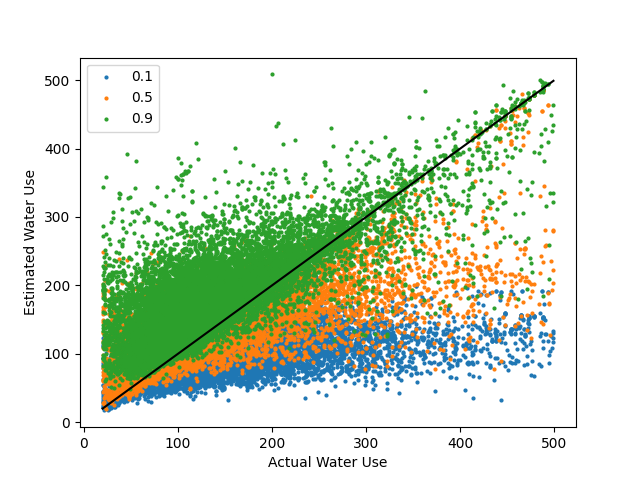

In [66]:
plt.figure()
for quantile_alpha, lgb in lgb_quantile_alphas.items():
    ypredict = lgb.predict(X_test)
    plt.scatter(y_test, ypredict, s = 4, label = "{}".format
                (quantile_alpha))
# plt.gca().set_yscale('log')
# plt.gca().set_xscale('log')
plt.legend()
lim = [min(y_test), max(y_test)]
plt.plot(lim, lim, 'k')
plt.xlabel("Actual Water Use")
plt.ylabel("Estimated Water Use")

# Dimension-reduction

In [ ]:
columns_to_drop = ['population', 'sys_id', 'wu_rate', 'pop', 'households2', 'n_employed', 'n_houses']
df = dataset.copy()

df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]


df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10, whiten = True)
pca.fit(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

In [ ]:
pca.transform(X)

# Testing more ideas for estimating Per Capita 

In [ ]:
def make_dataset(dataset = dataset, filters = [], drop_cols = [] ):
    pass
    


## No action

In [ ]:
 
columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()

df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]


df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

#squarederror
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)
gb = xgb.XGBRegressor(objective="reg:squarederror", colsample_bytree=0.8, learning_rate=0.1,
                              max_depth=7, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=0.0)

w = np.exp(1e-2*np.power((y_train-200)/10, 2.0))
w = w/np.sum(w)
w = w.values
w = w/np.max(w)
gb.fit(X_train, y_train, sample_weight=w/w)
plt.figure()
ypredict = gb.predict(X_test)

w2 = np.exp(1e-3*np.power((y_test-200)/10, 2.0))
w2 = w2/np.sum(w)
w2 = w2.values
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

In [ ]:

columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()
del(df['pc_median'])
df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>1000]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]


df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

# 
plt.figure()
v_freq = plt.hist(df['pc'].values, bins = 30)
freq = np.interp(df['pc'].values, v_freq[1][1:], v_freq[0], left=None, right=None, period=None)
X['freq'] = freq
#squarederror
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 123)
Train_freq = X_train['freq']
Test_freq = X_test['freq']
del(X_test['freq'])
del(X_train['freq'])

#squarederror
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)
gb = xgb.XGBRegressor(objective="reg:squarederror", tree_method = 'hist', colsample_bytree=0.8, learning_rate=0.20,
                              max_depth=7, alpha=100,  n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=10, min_child_weight = 1, gamma = 10, max_delta_step = 0, 
                           )
#gb = xgb.XGBRegressor(objective="reg:squarederror" )


w = 1.0/Train_freq
#w = w/np.sum(w)
w = w/np.max(w)
gb.fit(X_train, y_train, sample_weight=w/w)
plt.figure()
ypredict = gb.predict(X_test)

w2 = 1.0/Test_freq
#w2 = w2/np.sum(w)
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

# Use Pipeline 


In [ ]:


# (A.1) transformation of numeric features
numeric_features = ["age", "fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# (A.2) transformation of categorical features
categorical_features = ["embarked", "sex", "pclass"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")


# (A.3)do all preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

#  (B.1) complete pipeline
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

In [ ]:
from sklearn import set_config

set_config(display="diagram")
clf

In [ ]:
## Scaling

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pipeline = Pipeline([ ('robost_scaler', RobustScaler()),                     
                    ('model', gb)])
kwargs = {pipeline.steps[-1][0] + '__sample_weight': w/w}
pipeline.fit(X_train, y_train, **kwargs)

plt.figure()
ypredict = pipeline.predict(X_test)

w2 = 1.0/Test_freq
#w2 = w2/np.sum(w)
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

from sklearn.decomposition import PCA

pipeline = Pipeline([ ('uniform_dist', PowerTransformer()),                     
                    ('model', gb)])
kwargs = {pipeline.steps[-1][0] + '__sample_weight': w/w}
pipeline.fit(X_train, y_train, **kwargs)

plt.figure()
ypredict = pipeline.predict(X_test)

w2 = 1.0/Test_freq
#w2 = w2/np.sum(w)
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.decomposition import PCA

pipeline = Pipeline([ ('disc', KBinsDiscretizer(n_bins=1000, encode='ordinal', strategy='uniform')),                     
                    ('model', gb)])
kwargs = {pipeline.steps[-1][0] + '__sample_weight': w/w}
pipeline.fit(X_train, y_train, **kwargs)

plt.figure()
ypredict = pipeline.predict(X_test)

w2 = 1.0/Test_freq
#w2 = w2/np.sum(w)
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

In [ ]:
# plot feature importance
# ‘weight’: the number of times a feature is used to split the data across all trees.

# ‘gain’: the average gain across all splits the feature is used in.

# ‘cover’: the average coverage across all splits the feature is used in.

# ‘total_gain’: the total gain across all splits the feature is used in.

# ‘total_cover’: the total coverage across all splits the feature is used in.
plot_importance(gb,   xlabel='total_gain', importance_type='total_gain', max_num_features = 10)
from sklearn.feature_selection import SelectFromModel
plt.tight_layout()

In [ ]:
# Another look at importance

In [ ]:
plt.figure()
ypredict = gb.predict(X_test)

w2 = 1.0/Test_freq
#w2 = w2/np.sum(w)
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

In [ ]:
# Tuning
gb.get_params()
# params = {'colsample_bylevel': scipy.stats.uniform (loc = 0.1, scale=0.9),
#     'colsample_bynode': scipy.stats.uniform (loc = 0.1, scale=0.9),
#     'colsample_bytree': scipy.stats.uniform (loc = 0.1, scale=0.9),
#     'gamma': scipy.stats.uniform (loc = 0, scale=100),
#     'learning_rate': scipy.stats.uniform (loc = 0.001, scale=0.4),
#     'max_depth': [3,4,5,6,7,8,9, 10],
#     'min_child_weight' : scipy.stats.uniform (loc = 0 scale=1000),
#     'reg_alpha': 100,
#      'reg_lambda': 10,
#      'subsample': 0.8
#     }

In [ ]:
from pycaret.regression import *

columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()
del(df['pc_median'])
df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>1000]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]


df = df.drop(columns_to_drop, axis=1)
data = df.sample(frac=0.9, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

exp0 = setup(data = data2, target = 'pc', train_size = 0.8,                   
                   fold_shuffle= True, data_split_shuffle=True, session_id=123)
xgb = create_model('xgboost', fold = 3)
tuned_ada = tune_model(xgb)

In [ ]:
tuned_ada = tune_model(xgb)

In [ ]:
columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()

df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]


df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

In [ ]:
columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()

df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]


df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, whiten = True)
pca.fit(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)
X = pca.transform(X)

In [ ]:
#squarederror
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)
gb = xgb.XGBRegressor(objective='reg:"squarederror"', colsample_bytree=0.8, learning_rate=0.1,
                              max_depth=7, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=0.0)
gb.fit(X_train, y_train)

In [ ]:
plt.figure()
ypredict = gb.predict(X_test)
accuracy = r2_score(y_test, ypredict)
accuracy
accuracy = int(accuracy*100)/100.0
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

## Quantile transformation of the target PC
### Uniform Distribution

In [67]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import quantile_transform
from scipy import stats
x = pd.DataFrame(np.random.rand(100), columns = ['x'])
stats.percentileofscore(x['x'], 0.47219 )

46.0

In [68]:
from scipy import stats

In [69]:
# quantile transform
# columns to drop
columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()

df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]
pc_max = df['pc'].max()
pc_min = df['pc'].min()

df = df.drop(columns_to_drop, axis=1)
wu = quantile_transform(df['pc'].values.reshape(len(df),1), n_quantiles=5000, 
                        random_state=0) #, output_distribution = 'normal'
df['pc'] = wu.flatten()
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [71]:
#squarederror
gb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.1,
                              max_depth=7, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=0.0)

In [72]:
gb.fit(X_train, y_train)

XGBRegressor(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=24,
             num_parallel_tree=1, predictor='auto', random_state=123,
             rate_drop=0.9, reg_alpha=0.00999999978, reg_lambda=0.0,
             scale_pos_weight=1, seed=123, skip_drop=0.5, subsample=0.8,
             tree_method='exact', ...)

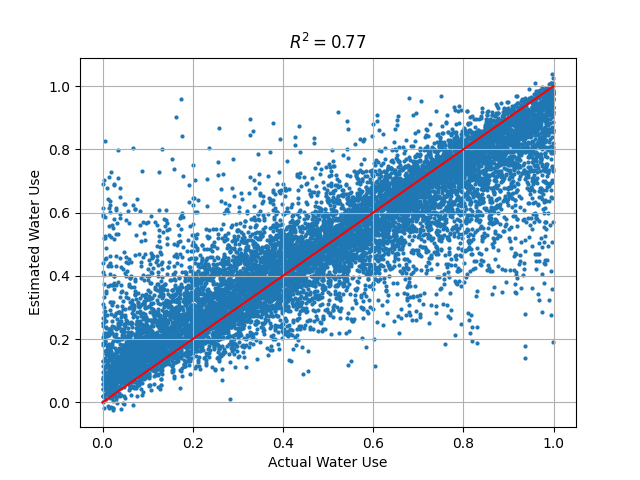

In [73]:
plt.figure()
ypredict = gb.predict(X_test)
accuracy = r2_score(y_test, ypredict)
accuracy
accuracy = int(accuracy*100)/100.0
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual Water Use")
plt.ylabel("Estimated Water Use")
plt.grid()
plt.show()

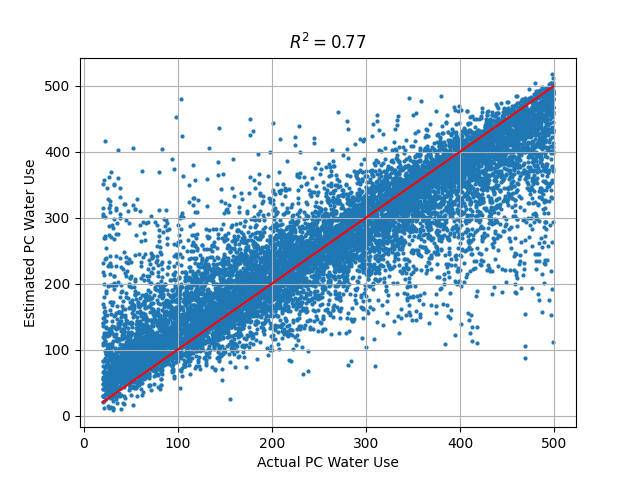

In [74]:
plt.figure()
ypredict = gb.predict(X_test)
ypredict = pc_min + ypredict*(pc_max-pc_min)
y_test = pc_min + y_test*(pc_max-pc_min)
accuracy = r2_score(y_test, ypredict)
accuracy
accuracy = int(accuracy*100)/100.0
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

## Normal Distribution

In [ ]:
# quantile transform
# columns to drop
columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()

df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]
pc_mean = df['pc'].mean()
pc_std= df['pc'].std()

df = df.drop(columns_to_drop, axis=1)
wu = quantile_transform(df['pc'].values.reshape(len(df),1), n_quantiles=5000, 
                        random_state=0, output_distribution = 'normal') #, output_distribution = 'normal'
df['pc'] = wu.flatten()
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [ ]:
gb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.1,
                              max_depth=7, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=0.0)

In [ ]:
gb.fit(X_train, y_train)

In [ ]:
plt.figure()
ypredict = gb.predict(X_test)
accuracy = r2_score(y_test, ypredict)
accuracy
accuracy = int(accuracy*100)/100.0
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

In [ ]:
pc_std

In [ ]:
plt.figure()
ypredict = gb.predict(X_test)

ypredict= 180+pc_mean + pc_std * ypredict
y_test = 180+pc_mean + pc_std * y_test
accuracy = r2_score(y_test, ypredict)

accuracy = int(accuracy*100)/100.0
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')

plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()